### Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

* id: id univoco dell'acquirente.
* Gender: sesso dell'acquirente.
* Age: età dell'acquirente.
* Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.
* Region_Code: codice univoco della regione dell'acquirente.
* Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
* Vehicle_Age: età del veicolo
* Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
* Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.
* Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
* Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.
* Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.


L'obiettivo del modello è prevedere il valore di Response.

Tip Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

Penalizzare la classe più frequente (ricorda l'argomento class_weight)
Utilizzare l'oversampling o l'undersampling (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/). 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier

In [8]:
df = pd.read_csv("../datasets/insurance_cross_sell.csv", index_col=0)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [9]:
#Dataset Information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB
None


#### We count the number of instances for each class in the target variable "Response" so we can see if they are unbalanced

In [10]:
print(df['Response'].value_counts())

Response
0    334399
1     46710
Name: count, dtype: int64


In [11]:
# Divide the dataset into features X and target variable y
X = df.drop('Response', axis=1)
y = df['Response']

In [12]:
# Creation of training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0 )

y_train.value_counts()

Response
0    267553
1     37334
Name: count, dtype: int64

In [13]:
# One-hot encoding for the variable 'Gender'
X_train_encoded = pd.get_dummies(X_train, columns=['Gender'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['Gender'], drop_first=True)

In [14]:
# Encoding the variable 'Vehicle_Age' in an ordinal way via a map
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

X_train_encoded['Vehicle_Age'] = X_train_encoded['Vehicle_Age'].map(vehicle_age_mapping)
X_test_encoded['Vehicle_Age'] = X_test_encoded['Vehicle_Age'].map(vehicle_age_mapping)

In [15]:
# Encoding the variable 'Vehicle_Damage' to binary
damage_mapping = {'Yes': 1, 'No': 0}

X_train_encoded['Vehicle_Damage'] = X_train_encoded['Vehicle_Damage'].map(damage_mapping)
X_test_encoded['Vehicle_Damage'] = X_test_encoded['Vehicle_Damage'].map(damage_mapping)

In [16]:
ss = StandardScaler()
X_train_encoded = ss.fit_transform(X_train_encoded)
X_test_encoded = ss.transform(X_test_encoded)

In [17]:
# Let's display the new encoded train set
X_train_encoded

array([[-1.14943478,  0.04618656,  0.12188185, ...,  0.73751583,
         0.94138471, -1.08454641],
       [-0.89144105,  0.04618656, -0.40742683, ...,  0.73751583,
         1.03694529, -1.08454641],
       [ 1.04351195,  0.04618656,  1.40734578, ...,  0.49774514,
         0.80998892,  0.92204445],
       ...,
       [-1.08493634,  0.04618656,  1.40734578, ...,  0.88506703,
        -0.43229861,  0.92204445],
       [ 1.10801038,  0.04618656,  1.25611473, ...,  0.82973533,
         0.89360442, -1.08454641],
       [-1.02043791,  0.04618656, -0.86111998, ...,  0.73751583,
        -0.87426629, -1.08454641]])

In [18]:
# Treats unbalanced classes using oversampling
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_encoded, y_train)

In [19]:
X_test_resampled, y_test_resampled = oversampler.fit_resample(X_test_encoded, y_test)

In [20]:
y_train_resampled.value_counts()

Response
0    267553
1    267553
Name: count, dtype: int64

In [21]:
# Linear Regression model
model = LogisticRegression(random_state=42, class_weight = 'balanced')
#model = LogisticRegression(random_state=42, class_weight= 'balanced')

In [22]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_resampled, y_train_resampled)

MLPClassifier(random_state=42)

In [23]:
# Train the Logistic Regression model
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(class_weight='balanced', random_state=42)

# We evaluate the model and print the classification report, confusion matrix and ROC Curve

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [25]:
y_pred = model.predict(X_test_resampled)

print(f'Accuracy: {accuracy_score(y_test_resampled, y_pred)}')
print(classification_report(y_test_resampled, y_pred))
#print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7849310355144661
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     66846
           1       0.71      0.98      0.82     66846

    accuracy                           0.78    133692
   macro avg       0.83      0.78      0.78    133692
weighted avg       0.83      0.78      0.78    133692



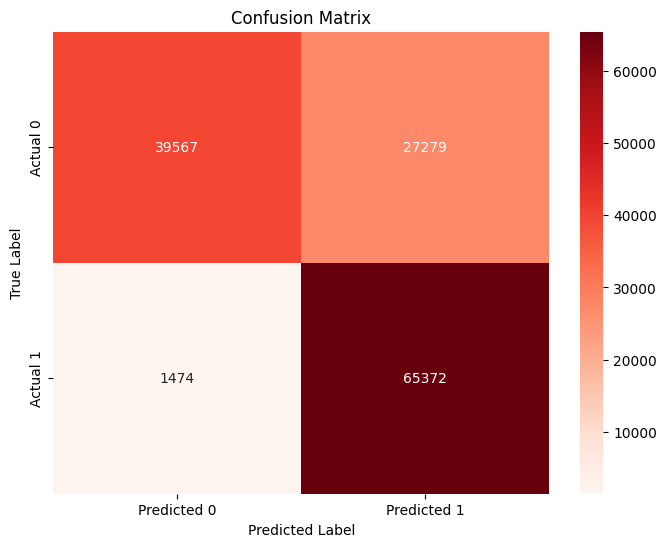

In [26]:
cm = confusion_matrix(y_test_resampled, y_pred)

#  DataFrame with confusion matrix values
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Reds')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

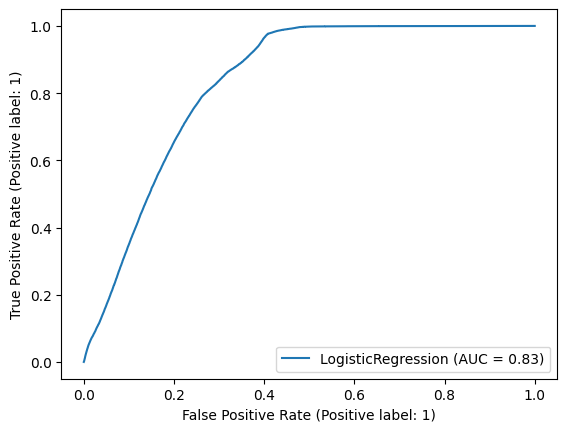

In [27]:
RocCurveDisplay.from_estimator(model, X_train_resampled, y_train_resampled)